[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/cdrc1103/MasterThesis/blob/master/Experiments/MultiClass/BERT.ipynb)

### Setup Notebook

In [1]:
!nvidia-smi

Fri May 28 12:08:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
%matplotlib inline
!pip install wandb
!pip install -qq transformers
!pip install datasets

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Data & Parameters



In [4]:
import json
from pathlib import Path
import pandas as pd

RUN_ID = "1.1_BERT768UNT"
BASE_DIR = Path(f"gdrive/MyDrive/Colab Notebooks/Thesis")
RUN_DIR = BASE_DIR / "MultiClass/Runs"

# Load parameters
class Parameter():
  def __init__(self):
    self.__dict__ = {
      "project_name": "thesis_multi-class",
      "train_dataset": "train_UNT.csv",
      "test_dataset": "test_UNT.csv",
      "embedding_dataset": "bert-base-uncased",
      "max_token_length": 30, # number of words/subwords, an instance is truncated to
      "max_tokens": 30000, # vocabulary size
      "embedding_dim": 768, # dimension of the pre-trained embeddings
      "batch_size": 32,
      "learning_rate": 3e-5,
      "epochs": 3,
      "seed": 1, # random seed for reproducability
      "logging": True, # whether to log to the wandb database (True) or to disk (False)
      "n_classes": 19, # how many unique labels there are in the data set
      "in_feature": "abstract", # feature used for training
      "out_feature": "label", # feature to predict
      "sample_weights": False, # whether weights for each training instance should be calculated depending on the label frequency
      "output_size": 768, # output size of the language processing layer, i.e. the CNN, GRU etc. layer
      "dropout_rate": 0.1, # for regularization
    }

# Save to disk          
PARAMS = Parameter()
with open(RUN_DIR / f"{RUN_ID}.json", "w") as f:
  json.dump(PARAMS.__dict__, f)

# Read data sets
train_df = pd.read_csv(BASE_DIR / PARAMS.train_dataset, index_col=0)
train_df = train_df.sample(frac=1, random_state=PARAMS.seed)
test_df = pd.read_csv(BASE_DIR / PARAMS.test_dataset, index_col=0)
test_df = test_df.sample(frac=1, random_state=PARAMS.seed)

# Print stats
print(f"Train data set:{len(train_df)} instances")
print(f"Test data set:{len(test_df)} instances")

Train data set:79075 instances
Test data set:26359 instances


## Configure logging

In [5]:
# Logging
import wandb

# log to wandb
if PARAMS.logging:
    !wandb login
    run = wandb.init(project=PARAMS.project_name, sync_tensorboard=True)
    run.name = RUN_ID
    log_dir = Path(wandb.run.dir)
    wandb.config.update(PARAMS.__dict__)
# log to disk
else:
    log_dir = RUN_DIR

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


wandb: Currently logged in as: cdrc1103 (use `wandb login --relogin` to force relogin)


## Model

In [6]:
""" Dependencies """
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Bidirectional, GRU, Embedding
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from transformers import TFBertModel, BertTokenizerFast, BertConfig
from datasets import Dataset

""" Apply weights to samples """
if PARAMS.sample_weights:
  # Determine class weights to reduce class imbalance
  class_weight = {}
  total_instances = len(train_df)
  class_freqs = train_df[PARAMS.out_feature].value_counts()
  for class_id, freq in zip(class_freqs.index, class_freqs):
      class_weight[class_id] = total_instances / (freq * PARAMS.n_classes)
  sample_weight = np.zeros(len(train_df))
  for i, class_id in enumerate(train_df[PARAMS.out_feature]):
      sample_weight[i] = class_weight[class_id]

""" Configure tokenizer """
config = BertConfig.from_pretrained(PARAMS.embedding_dataset)
config.num_labels=PARAMS.n_classes
tokenizer = BertTokenizerFast.from_pretrained(PARAMS.embedding_dataset, config=config)

""" Create TF datasets """
# Aggregate features
train_ds = Dataset.from_pandas(train_df)
test_ds = Dataset.from_pandas(test_df)

# Tokenize
def tokenize(batch):
    return tokenizer(batch[PARAMS.in_feature], truncation=True, padding=True, max_length=PARAMS.max_token_length)
train_ds = train_ds.map(tokenize, batched=True, batch_size=32)
test_ds = test_ds.map(tokenize, batched=True, batch_size=32)

# Transform to tensorflow data set 
train_ds.set_format(type='tensorflow', columns=['attention_mask','input_ids', 'label'])
train_features = {x: train_ds[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
train_ds = (train_features, to_categorical(train_ds[PARAMS.out_feature], num_classes=PARAMS.n_classes))
# Whether to add weights to data set
if PARAMS.sample_weights:
  train_ds = train_ds + (sample_weight,)
train_ds = tf.data.Dataset.from_tensor_slices(train_ds).batch(32)
# Transform validation data set
test_ds.set_format(type='tensorflow', columns=['attention_mask','input_ids', 'label'])
test_features = {x: test_ds[x].to_tensor(default_value=0) for x in ['input_ids', 'attention_mask']}
test_ds = tf.data.Dataset.from_tensor_slices((test_features, to_categorical(test_ds[PARAMS.out_feature], num_classes=PARAMS.n_classes))).batch(32)

""" Define model architecture """
def build_model():
  input_ids = Input(shape=PARAMS.max_token_length, name='input_ids', dtype='int32')
  attention_mask = Input(shape=PARAMS.max_token_length, name='attention_mask', dtype='int32')
  transformer_model = TFBertModel.from_pretrained(PARAMS.embedding_dataset, config=config)
  embedding = transformer_model.layers[0](input_ids, attention_mask=attention_mask)[1]
  dropout = Dropout(PARAMS.dropout_rate)(embedding)
  output = Dense(PARAMS.n_classes, activation='softmax')(dropout)
  return Model(inputs={"input_ids": input_ids, "attention_mask": attention_mask}, outputs=output)

model = build_model()

""" Setup otimization """
# Set an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=PARAMS.learning_rate, epsilon=1e-08, clipnorm=1.0)
# Set loss and metrics
loss = CategoricalCrossentropy()
metrics = [
  Precision(name='precision'), # tp / (tp+fp)
  CategoricalAccuracy(name='accuracy'), # (tp+tn) / (tp+fp+tn+fn)
  Recall(name='recall') # tp / (tp + fn)
]

# Compile the model
model.compile(
  optimizer=optimizer,
  loss=loss,
  metrics=metrics)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [7]:
from contextlib import redirect_stdout

""" Generate model summary """
print(model.summary())
with open(log_dir/'model_summary.txt', 'w') as file:
    # Pass the file handle in as a lambda function to make it callable
    model.summary(print_fn=lambda x: file.write(x + '\n'))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 30)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 30)]         0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 768)          0           bert[0][1]                   

## Training

In [8]:
from tensorflow.keras.callbacks import TensorBoard
# setup callback for performance logging
tensorboard_callback = TensorBoard(log_dir=log_dir/"logs",
                                   histogram_freq=0,
                                   write_graph=False,
                                   write_images=False,
                                   update_freq=100)

# train the model
history = model.fit(
    x=train_ds,
    epochs=PARAMS.epochs,
    callbacks=[tensorboard_callback],
    verbose=1,
    validation_data=test_ds
    )

Epoch 1/3
2472/2472 [==============================] - ETA: 0s - loss: 1.0289 - precision: 0.7361 - accuracy: 0.6442 - recall: 0.5475

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init


2472/2472 [==============================] - 654s 257ms/step - loss: 1.0289 - precision: 0.7361 - accuracy: 0.6442 - recall: 0.5475 - val_loss: 0.8453 - val_precision: 0.7682 - val_accuracy: 0.7078 - val_recall: 0.6422
Epoch 2/3
2472/2472 [==============================] - 635s 257ms/step - loss: 0.7612 - precision: 0.7884 - accuracy: 0.7338 - recall: 0.6755 - val_loss: 0.8073 - val_precision: 0.7678 - val_accuracy: 0.7244 - val_recall: 0.6803
Epoch 3/3
2472/2472 [==============================] - 634s 256ms/step - loss: 0.5913 - precision: 0.8302 - accuracy: 0.7928 - recall: 0.7547 - val_loss: 0.8328 - val_precision: 0.7625 - val_accuracy: 0.7335 - val_recall: 0.7084


## Evaluate

In [9]:
# Get predictions on test dataset
predictions = model.predict(
    x=test_ds,
    verbose=1,
    batch_size=PARAMS.batch_size
) # Probability distribution over the labels
np.savetxt(log_dir/"predictions.txt", predictions)

pred_label =np.argmax(predictions, axis=1) # select the prediction with highest probability
true_label = test_df[PARAMS.out_feature].to_numpy() # select the true label from one-hot encoding

824/824 [==============================] - 63s 74ms/step


In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"]})
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, brier_score_loss, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import math

In [11]:
""" Brier score """
def brier(true_label, pred_label, n_classes):
  brier_scores = {}
  for i in range(n_classes):
    row_id = np.where(true_label==i)[0]
    prob = pred_label[row_id, i]
    true = np.ones(len(prob))
    brier_scores[i] = brier_score_loss(true, prob).round(2)
  return brier_scores
brier_scores = brier(true_label, predictions, PARAMS.n_classes)
if PARAMS.logging:
  wandb.log({"brier": brier_scores})
brier_scores

{0: 0.33,
 1: 0.17,
 2: 0.27,
 3: 0.09,
 4: 0.14,
 5: 0.16,
 6: 0.29,
 7: 0.22,
 8: 0.19,
 9: 0.23,
 10: 0.35,
 11: 0.49,
 12: 0.62,
 13: 0.67,
 14: 0.68,
 15: 0.23,
 16: 0.61,
 17: 1.0,
 18: 1.0}

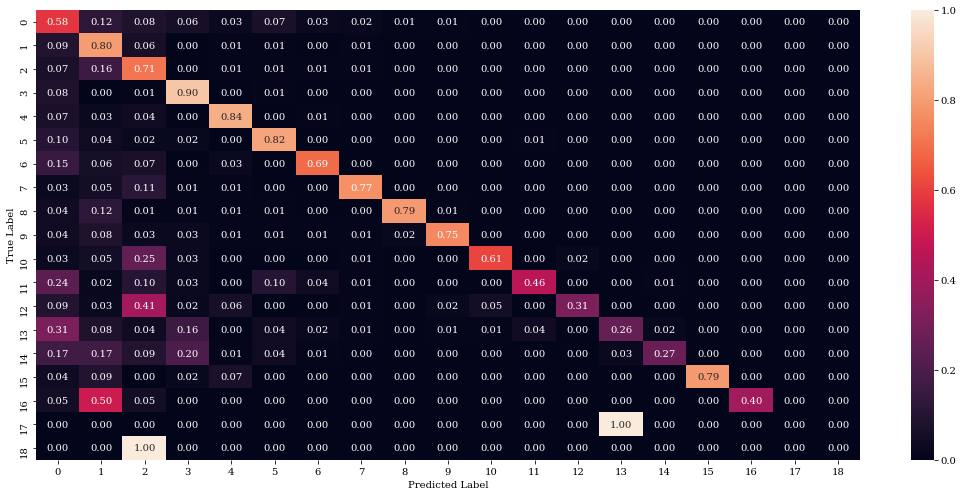

In [12]:
""" Confusion matrix """
def plot_cm(true_label, pred_label, n_classes):
    # compute values
    cm = confusion_matrix(true_label, pred_label, labels=np.arange(0,n_classes))
    # normalize values
    sum_per_label = np.sum(cm, axis=1)
    cm_norm = cm / sum_per_label[:, None]
    cm_norm =np.round(cm_norm, 2)
    # plot
    fig = plt.figure(figsize=(15,7))
    sns.heatmap(cm_norm, annot=True, fmt=".2f")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.plot()
    return fig

fig = plot_cm(true_label, pred_label, PARAMS.n_classes)
fig.savefig(log_dir/"confusion.png", dpi=150)

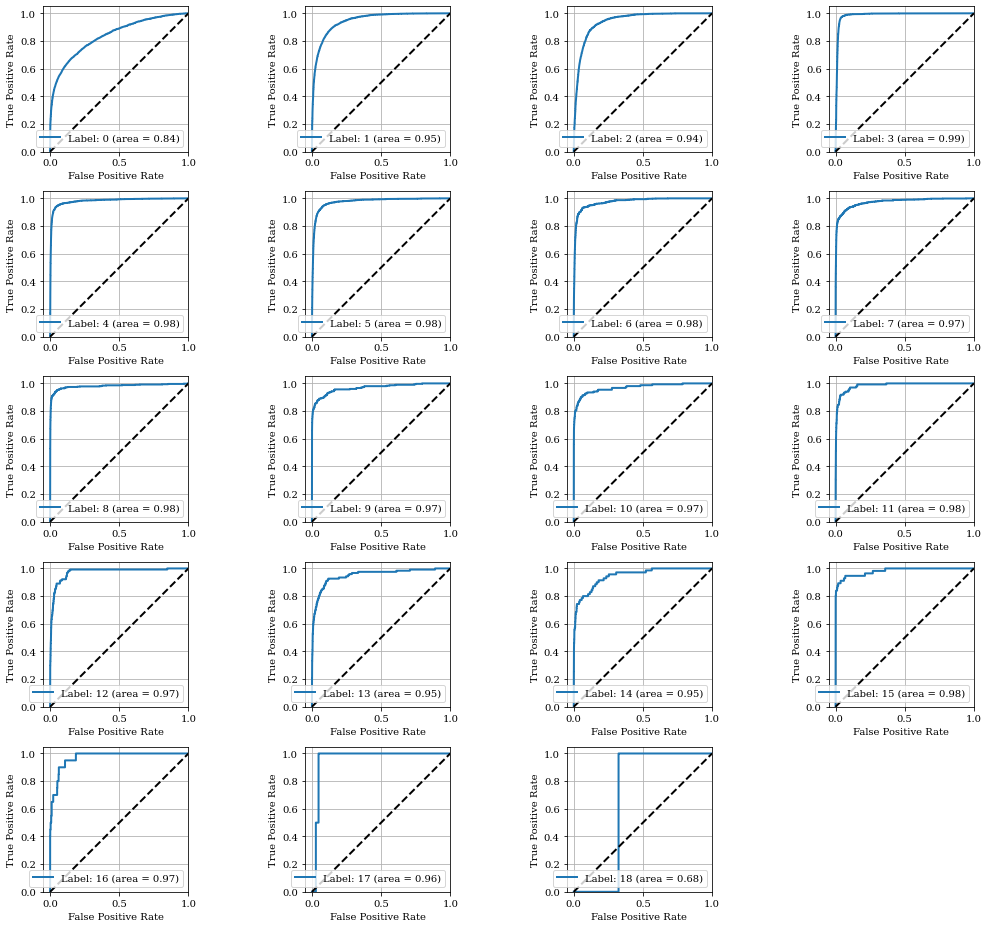

In [13]:
""" Receiver operating characteristic """
def plot_roc(true_label, pred_label, n_classes):
    fig = plt.figure(figsize=(15, 13))
    linewidth = 2
    fpr = {}
    tpr = {}
    roc_auc = {}
    cols = math.floor(math.sqrt(n_classes))
    rows = math.ceil(n_classes / cols)
    
    # calculate class-wise rocs
    for i in range(n_classes):
        row_id = np.where(true_label==i)[0]
        binary_truth = np.zeros(len(true_label))
        binary_truth[row_id] = 1
        fpr[i], tpr[i], _ = roc_curve(binary_truth, pred_label[:,i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.subplot(rows, cols, i+1)
        plt.plot(fpr[i], tpr[i], linewidth=linewidth,
                 label='Label: %i (area = %0.2f)' % (i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='black', lw=linewidth, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.xlim([-0.05, 1])
        plt.ylim([0, 1.05])
        plt.grid(True)
        plt.legend(loc='lower right')
        ax = plt.gca()
        ax.set_aspect('equal')
    plt.tight_layout()
    return fig

roc = plot_roc(true_label, predictions, PARAMS.n_classes)
roc.savefig(log_dir/"roc.png", dpi=150)

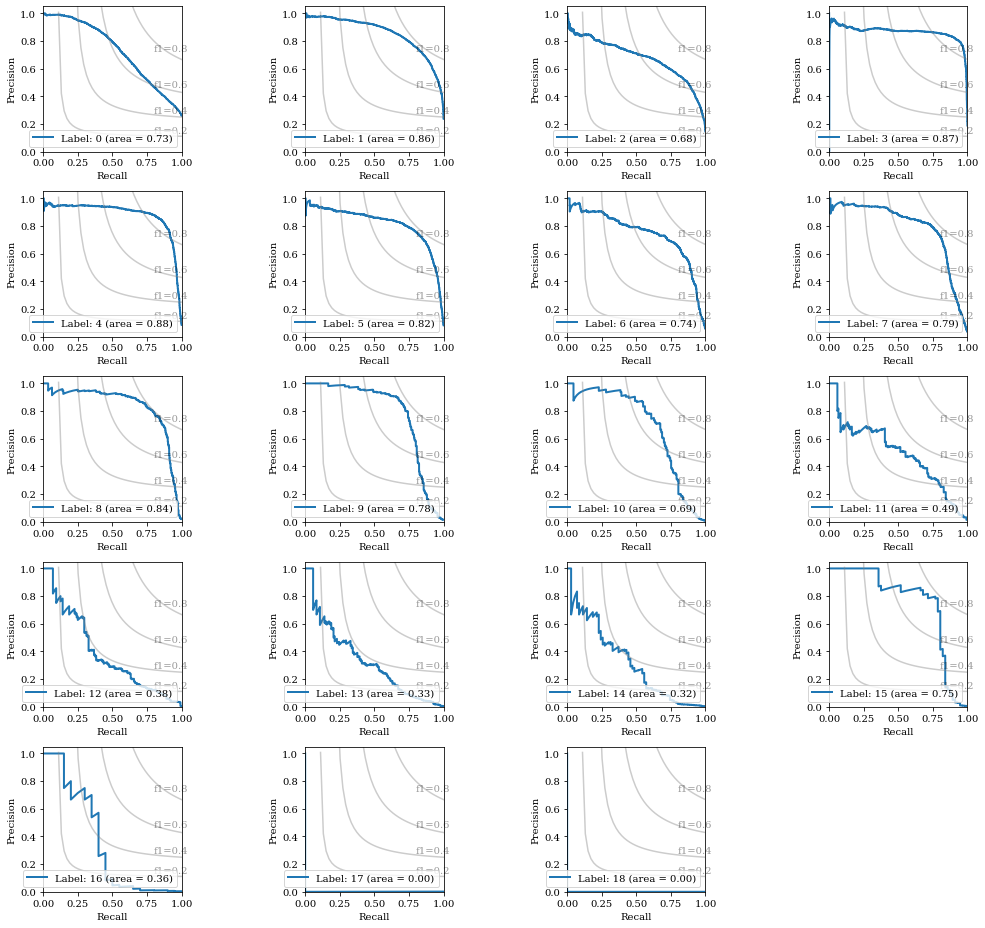

In [14]:
def plot_prec(true_label, pred_label, n_classes):
  precision = dict()
  recall = dict()
  average_precision = dict()
  fig = plt.figure(figsize=(15, 13))
  linewidth = 2
  cols = math.floor(math.sqrt(n_classes))
  rows = math.ceil(n_classes / cols)

  for i in range(n_classes):
      row_id = np.where(true_label==i)[0]
      binary_truth = np.zeros(len(true_label))
      binary_truth[row_id] = 1
      precision[i], recall[i], _ = precision_recall_curve(binary_truth, pred_label[:,i])
      average_precision[i] = average_precision_score(binary_truth, pred_label[:,i])

      plt.subplot(rows, cols, i+1)
      plt.plot(recall[i], precision[i], lw=linewidth, label="Label: %i (area = %0.2f)" %(i, average_precision[i]))
      plt.legend(loc='lower right')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('Recall')
      plt.ylabel('Precision')
      f_scores = np.linspace(0.2, 0.8, num=4)
      lines = []
      labels = []
      for f_score in f_scores:
          x = np.linspace(0.01, 1)
          y = f_score * x / (2 * x - f_score)
          l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.4)
          plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.8, y[45] + 0.02), alpha=0.4)
      ax = plt.gca()
      ax.set_aspect('equal')
  plt.tight_layout()

  return fig

prec = plot_prec(true_label, predictions, PARAMS.n_classes)
prec.savefig(log_dir/"prec.png", dpi=150)

In [15]:
""" Classification report """
def create_report(true_label, pred_label, n_classes):
  cls_names =[str(cls) for cls in np.arange(0, n_classes)]
  cls_report = classification_report(true_label, pred_label, target_names=cls_names, output_dict=True)
  return pd.DataFrame(cls_report).round(2).transpose()

cls_report = create_report(true_label, pred_label, PARAMS.n_classes)
cls_report.to_csv(log_dir/"cls_report.csv")
if PARAMS.logging:
  wandb.log({"f1-score": cls_report["f1-score"].to_dict()})
cls_report

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.70,0.58,0.63,6817.00
1,0.75,0.80,0.77,6152.00
2,0.61,0.71,0.66,3038.00
3,0.82,0.90,0.86,2865.00
4,0.85,0.84,0.84,2146.00
5,0.73,0.82,0.78,1995.00
6,0.72,0.69,0.70,1012.00
7,0.77,0.77,0.77,845.00
8,0.79,0.79,0.79,503.00
9,0.72,0.75,0.73,300.00


## Save loggings

In [16]:
""" Submit results """
if PARAMS.logging:
    run.join()
    run.finish()

train/global_step,2
_timestamp,1622205967.03343
global_step,7416
_step,79
train/batch_loss,0.59152
train/batch_precision,0.8302
train/batch_accuracy,0.79278
train/batch_recall,0.75461
train/epoch_loss,0.59129
train/epoch_precision,0.83019
train/epoch_accuracy,0.7928


train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▁▄▄▄▄▄▅▅▅▅▅▅▆▁▆▆▆▆▇▇▇▇▇███▁
_timestamp,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train/batch_loss,█▆▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train/batch_precision,▁▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇████████████
train/batch_accuracy,▁▃▄▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
train/batch_recall,▁▃▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train/epoch_loss,█▄▁
train/epoch_precision,▁▅█
train/epoch_accuracy,▁▅█
